# Tugas Besar IF3270 Pembelajaran Mesin
### Kelompok 26

Anggota:
- 13521074 Eugene Yap Jin Quan
- 13521137 Michael Utama
- 13521138 Johann Christian Kandani
- 13521173 Dewana Gustavus Haraka Otang

## Imports

In [ ]:
%pip install -q scikit-learn
%pip install -q viznet
%pip install -q pandas
%pip install -q keras
%pip install -q tensorflow

import pandas as pd
import numpy as np
import json
import viznet
import pickle
import matplotlib.pyplot as plt
import math

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import SGD

from types import SimpleNamespace

## Input Data Class

In [ ]:
class Layer:
    number_of_neurons: int
    activation_function: str

class Model:
    input_size: int
    layers: list[Layer]

class LearningParameters:
    learning_rate: float
    batch_size: int
    max_iteration: int
    error_threshold: float

class Case:
    model: Model
    input: list[list[float]]
    initial_weights: list[list[list[float]]]
    target: list[list[float]]
    learning_parameters: LearningParameters

class Expect:
    stopped_by: str
    final_weights: list[list[list[float]]]

class InputData:
    case: Case
    expect: Expect

# Fungsi Individu

### Read JSON

In [ ]:
def read_json(filename: str) -> InputData:
    data: InputData | None = None

    with open(filename) as file:
        data = json.loads(file.read(), object_hook=lambda d: SimpleNamespace(**d))

    if data is None:
        raise FileNotFoundError

    return data

### Activation Function

In [ ]:
def _Linear(net: float) -> float:
    return net

def _ReLU(net: float) -> float:
    return max(0., net)

def _Sigmoid(net: float) -> float:
    denominator = (1 + np.exp(-net))
    value = 1 / denominator
    return value

def Softmax(net: np.ndarray) -> np.ndarray:
    exp_net = np.exp(net - np.max(net))
    denominator = np.sum(exp_net)
    values = np.divide(exp_net, denominator)
    return values

Linear = np.vectorize(_Linear)
ReLU = np.vectorize(_ReLU)
Sigmoid = np.vectorize(_Sigmoid)

In [ ]:
def Sum_squared_error(out: np.ndarray, target: np.ndarray) -> float:
    error = np.sum([(t - o)**2 for t, o in zip(target, out)])
    return error

def Log_error(p: np.ndarray, target: np.ndarray) -> float:
    error = -math.log(np.dot(p, target))
    return error

### Function Derivatives

In [ ]:
def _Linear_derivative(_o: float) -> float:
    return 1.0

def _ReLU_derivative(o: float) -> float:
    if o <= 0:
        return 0.0
    else:
        return 1.0

def _Sigmoid_derivative(o: float) -> float:
    sigmoid = o
    value = sigmoid * (1 - sigmoid)
    return value

def Softmax_derivative(_o: float) -> float:
    return 1

Linear_derivative = np.vectorize(_Linear_derivative)
ReLU_derivative = np.vectorize(_ReLU_derivative)
Sigmoid_derivative = np.vectorize(_Sigmoid_derivative)

In [ ]:
def Sum_squared_error_derivative(out: np.ndarray, target: np.ndarray) -> np.ndarray:
    return out - target

def Log_error_softmax_derivative(out: np.ndarray, target: np.ndarray) -> np.ndarray:
    check = lambda p, k: p if k != 1 else p - 1
    return [check(p, k) for p, k in zip(out, target)]

### Wrapper Function

In [ ]:
def calculate_activation_derivative(out: np.ndarray, activation: str) -> float:
    match activation:
        case "linear":
            return Linear_derivative(out)
        case "relu":
            return ReLU_derivative(out)
        case "sigmoid":
            return Sigmoid_derivative(out)
        case "softmax":
            return Softmax_derivative(out)

def calculate_error_derivative(out: np.ndarray, target: np.ndarray, activation: str) -> np.ndarray:
    match activation:
        case "linear":
            return Sum_squared_error_derivative(out, target)
        case "relu":
            return Sum_squared_error_derivative(out, target)
        case "sigmoid":
            return Sum_squared_error_derivative(out, target)
        case "softmax":
            return Log_error_softmax_derivative(out, target)

In [ ]:
def count_error_term(o: np.ndarray, t: np.ndarray, type: str) -> np.ndarray:
    if type == 'softmax':
        return t - o
    else:
        if type == 'linear':
            fun = Linear_derivative
        elif type == 'relu':
            fun = ReLU_derivative
        elif type == 'sigmoid':
            fun = Sigmoid_derivative
        else:
            raise Exception("No such method")

        return fun(o) * (t - o)

### Hitung / Feed Forward

In [ ]:
# input         : 1d array
# weight        : list of 2d array
# activation    : 1d array

class NeuralNetwork:
    def __init__(self, weights: list[np.ndarray], activation_functions: list[str]):
        self.weights = weights
        self.activation_functions = activation_functions
        self.stopped_by = ""
        self.values = []

    def ffnn(self, input: np.ndarray) -> np.ndarray:
        self.values = []
        next = input
        for weight, activation in zip(self.weights, self.activation_functions):
            current = np.insert(next, 0, 1., axis=0)
            next = weight.transpose().dot(current)
            match activation:
                case "linear":
                    next = Linear(next)
                case "relu":
                    next = ReLU(next)
                case "sigmoid":
                    next = Sigmoid(next)
                case "softmax":
                    next = Softmax(next)

            self.values += [current]
        self.values += [next]

        return next

    # Call after forward propagation
    # target: single target
    # return delta matrix for single instance
    def __backward_propagation(self, target: np.ndarray):
        # weight change by this operation
        delta_w: list[np.ndarray] = [np.zeros(x.shape) for x in self.weights]

        # calculate output error term
        error_term = count_error_term(self.values[-1], target, self.activation_functions[-1])

        delta_w[-1] = error_term[np.newaxis,:] * self.values[-2][:, np.newaxis]

        # Loop from output to input
        for i in range(len(self.weights)-2, -1, -1):
            # select derivative func
            if self.activation_functions[i] == 'linear':
                derivative_fun = Linear_derivative
            elif self.activation_functions[i] == 'relu':
                derivative_fun = ReLU_derivative
            elif self.activation_functions[i] == 'sigmoid':
                derivative_fun = Sigmoid_derivative
            else:
                raise Exception(f"No such activation function {self.activation_functions[i]}")

            # calculate hidden layer error term
            next_error_term = derivative_fun(self.values[i+1][1:]) * self.weights[i+1].dot(error_term)[1:]
            # update delta_w
            delta_w[i] = next_error_term[np.newaxis,:] * self.values[i][:,np.newaxis]

            error_term = next_error_term

        return delta_w

    def train(self, learning_parameters: LearningParameters, input: list[np.ndarray], target: list[np.ndarray]):
        for iter in range(learning_parameters.max_iteration):
            no_in_batch = 0
            delta_w = [np.zeros(x.shape) for x in self.weights]

            total_err = 0

            for x, y in zip(input, target):
                output = self.ffnn(x)
                total_err += Log_error(y, output) if self.activation_functions[-1] == 'softmax' else Sum_squared_error(y, output)
                delta_delta_w = self.__backward_propagation(y)

                for i in range(len(delta_w)):
                    delta_w[i] += delta_delta_w[i]

                no_in_batch += 1
                if no_in_batch == learning_parameters.batch_size:
                    for i in range(len(self.weights)):
                        self.weights[i] += learning_parameters.learning_rate * delta_w[i]
                    delta_w = [np.zeros(x.shape) for x in self.weights]
                    no_in_batch = 0

            if no_in_batch > 0:
                for i in range(len(self.weights)):
                    self.weights[i] += learning_parameters.learning_rate * delta_w[i]

            average_err = total_err / len(input)

            if average_err <= learning_parameters.error_threshold:
                self.stopped_by = "error_threshold"
                self.after_train()
                return

        self.stopped_by = "max_iteration"
        self.after_train()
        return

    # Cleanup so temporary values not saved
    def after_train(self):
        self.values = []



# Fungsi Integrasi

### Tampilkan model

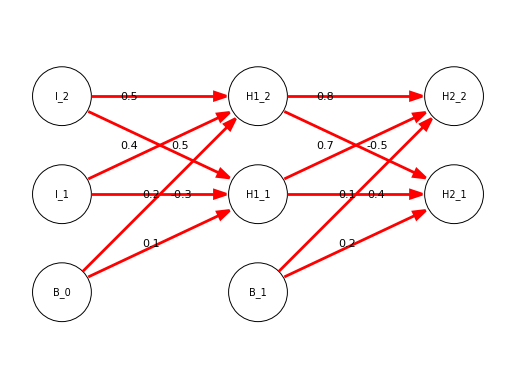

In [ ]:
def plt_show():
    plt.axis('off')
    plt.axis('equal')
    plt.show()

def draw_graph(case: Case):
    # Viznet
    grid = viznet.Grid((2.0, 1.0))
    brush = viznet.NodeBrush('basic')
    edge_brush = viznet.EdgeBrush('->', lw=2, color='r')
    NODE_FONT_SIZE = 7
    EDGE_FONT_SIZE = 8
    EDGE_NODE_RATIO = 3

    layers_nodes: list[list[viznet.Node | None]] = [[] for _ in range(len(case.model.layers) + 1)]

    # Bias nodes
    for i in range(len(layers_nodes) - 1):
        node = brush >> grid[i, 0]
        node.text(f"B_{i}", fontsize=NODE_FONT_SIZE)
        layers_nodes[i].append(node)
    layers_nodes[-1].append(None)

    # Input layer
    input_nodes: list[viznet.Node | None] = layers_nodes[0]
    for i in range(case.model.input_size):
        node = brush >> grid[0, i+1]
        node.text(f"I_{i+1}", fontsize=NODE_FONT_SIZE)
        input_nodes.append(node)

    max_layer_num_of_neuron = 0
    for layer in case.model.layers:
        max_layer_num_of_neuron = layer.number_of_neurons if (layer.number_of_neurons > max_layer_num_of_neuron) else max_layer_num_of_neuron
    # Hidden layers
    for i, layer in enumerate(case.model.layers):
        y_ratio = max_layer_num_of_neuron/layer.number_of_neurons
        for j in range(layer.number_of_neurons):
            node = brush >> grid[i+1, (j+1)*y_ratio]
            node.text(f"H{i+1}_{j+1}", fontsize=NODE_FONT_SIZE)
            layers_nodes[i+1].append(node)

    # Connecting edges
    for i, layer_weights in enumerate(case.initial_weights):
        for j, current_node in enumerate(layers_nodes[i]):
            offset_ratio = 1 / (EDGE_NODE_RATIO * len(layers_nodes[i]))
            for k, next_node in enumerate(layers_nodes[i + 1][1:]):
                edge = edge_brush >> (current_node, next_node)
                position = 'right' if j % 2 else 'left'
                edge.text(f"{layer_weights[j][k]}", position, fontsize=EDGE_FONT_SIZE, text_offset=j*offset_ratio)

    # Draw
    plt_show()

draw_graph(read_json('tcB/mlp.json').case)

### Proses input data to model

In [ ]:
def input_data_to_model(data: InputData) -> NeuralNetwork:
    weights = [np.array(x) for x in data.case.initial_weights]
    activations = [x.activation_function for x in data.case.model.layers]

    return NeuralNetwork(weights, activations)


### Proses batch

In [ ]:
test_cases = [
    "tcB/linear.json",
    "tcB/linear_small_lr.json",
    "tcB/linear_two_iteration.json",
    "tcB/mlp.json",
    "tcB/relu_b.json",
    "tcB/sigmoid.json",
    "tcB/softmax.json",
    "tcB/softmax_two_layer.json",
]

for test_case in test_cases:
    data = read_json(test_case)
    model = input_data_to_model(data)

    model.train(
        learning_parameters=data.case.learning_parameters,
        input=data.case.input,
        target=data.case.target
    )

    # output formatting
    expected_final_weights = [np.array(x) for x in data.expect.final_weights]

    print("testcase:", test_case)
    print("expected result:")
    print("stopped by:", data.expect.stopped_by)
    print("final weights:")
    print(expected_final_weights[0])
    print()
    print("training result:")
    print("stopped by:", model.stopped_by)
    print("final weights:")
    print(model.weights[0])
    print()

testcase: tcB/linear.json
expected result:
stopped by: max_iteration
final weights:
[[ 0.22  0.36  0.11]
 [ 0.64  0.3  -0.89]
 [ 0.28 -0.7   0.37]]

training result:
stopped by: max_iteration
final weights:
[[ 0.22  0.36  0.11]
 [ 0.64  0.3  -0.89]
 [ 0.28 -0.7   0.37]]

testcase: tcB/linear_small_lr.json
expected result:
stopped by: max_iteration
final weights:
[[ 0.1008  0.3006  0.1991]
 [ 0.402   0.201  -0.7019]
 [ 0.101  -0.799   0.4987]]

training result:
stopped by: max_iteration
final weights:
[[ 0.1012  0.3006  0.1991]
 [ 0.4024  0.201  -0.7019]
 [ 0.1018 -0.799   0.4987]]

testcase: tcB/linear_two_iteration.json
expected result:
stopped by: max_iteration
final weights:
[[ 0.166  0.338  0.153]
 [ 0.502  0.226 -0.789]
 [ 0.214 -0.718  0.427]]

training result:
stopped by: max_iteration
final weights:
[[ 0.166  0.338  0.153]
 [ 0.502  0.226 -0.789]
 [ 0.214 -0.718  0.427]]

testcase: tcB/mlp.json
expected result:
stopped by: max_iteration
final weights:
[[ 0.08592   0.32276 ]
 [-

### Save and load model

In [ ]:
data: InputData = read_json('tcB/softmax_two_layer.json')
model = input_data_to_model(data)
model.train(
    learning_parameters=data.case.learning_parameters,
    input=data.case.input,
    target=data.case.target
)

with open('model_save.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
with open('model_save.pkl', 'rb') as file:
    loaded_model: NeuralNetwork = pickle.load(file)

# output formatting
expected_final_weights = [np.array(x) for x in data.expect.final_weights]

ffnn_output = [loaded_model.ffnn(input) for input in data.case.input]
ffnn_output = [[round(x, 4) for x in output] for output in ffnn_output]

print("expected result:")
print("stopped by:", data.expect.stopped_by)
print("model output:")
print(*data.case.target, sep='\n')
print("final weights:")
print(expected_final_weights[0])
print()
print("model result:")
print("stopped by:", loaded_model.stopped_by)
print("model output:")
print(*ffnn_output, sep='\n')
print("final weights:")
print(loaded_model.weights[0])

expected result:
stopped by: error_threshold
model output:
[0, 1]
[1, 0]
[0, 1]
[1, 0]
[1, 0]
[0, 1]
[1, 0]
[0, 1]
final weights:
[[-0.28730211 -0.28822282 -0.70597451  0.42094471]
 [-0.5790794  -1.1836444  -1.34287961  0.69575311]
 [-0.41434377  1.51314676 -0.97649086 -1.3043465 ]]

model result:
stopped by: error_threshold
model output:
[0.0304, 0.9696]
[0.9998, 0.0002]
[0.0048, 0.9952]
[1.0, 0.0]
[0.9938, 0.0062]
[0.0017, 0.9983]
[0.9965, 0.0035]
[0.0304, 0.9696]
final weights:
[[-0.28730211 -0.28822282 -0.70597451  0.42094471]
 [-0.5790794  -1.1836444  -1.34287961  0.69575311]
 [-0.41434377  1.51314676 -0.97649086 -1.3043465 ]]


## Iris Dataset Performance Comparison

### Read iris dataset

In [ ]:
# Read iris.csv
iris_df = pd.read_csv("tcB/iris.csv")

# Extract attributes and targets
attributes = iris_df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].values
target_values = iris_df['Species'].values

# Encode target values
label_encoder = preprocessing.LabelEncoder()
target = label_encoder.fit_transform(target_values)
number_classes = len(set(target_values))

print("Target values (Species):", list(set(target_values)))
print("Data count:", len(attributes))

Target values (Species): ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
Data count: 150


In [ ]:
iris_df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


### MLPClassifier on iris.csv

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(attributes, target, shuffle=True, random_state=1)

print("Train data count:", len(X_train))
print("Test data count:", len(X_test))

# test MLP performance
learning_rate = 0.1

clf = MLPClassifier(hidden_layer_sizes=(10, 10, 10,),
                    activation="logistic",
                    max_iter=420,
                    batch_size=10,
                    solver="adam",
                    learning_rate="constant",
                    learning_rate_init=learning_rate).fit(X_train, y_train)
print("Prediction probabilities:", clf.predict_proba(X_test[:1]))
print('Test accuracy:', clf.score(X_test, y_test))

Train data count: 112
Test data count: 38
Prediction probabilities: [[0.99273101 0.0052438  0.00202519]]
Test accuracy: 0.9473684210526315


### Keras on iris.csv

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(attributes, target, shuffle=True, random_state=1)
y_train = to_categorical(y_train, num_classes=number_classes)
y_test = to_categorical(y_test, num_classes=number_classes)

print("Train data count:", len(x_train))
print("Test data count:", len(x_test))

input_size = len(attributes[0])

model = Sequential()
model.add(Dense(10, activation='linear', input_shape=(input_size,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(number_classes, activation='softmax'))

model.summary()

Train data count: 112
Test data count: 38
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                50        
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 3)                 33        
                                                                 
Total params: 303 (1.18 KB)
Trainable params: 303 (1.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Learning parameters
learning_rate = 0.1
error_threshold = 0.1
batch_size = 10
max_iteration = 420

model.compile(loss="categorical_crossentropy",
                optimizer=SGD(learning_rate=learning_rate),
                metrics = ['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=max_iteration)
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/420
12/12 [==============================] - 1s 3ms/step - loss: 1.0790 - accuracy: 0.5089
Epoch 2/420
12/12 [==============================] - 0s 3ms/step - loss: 0.9309 - accuracy: 0.5982
Epoch 3/420
12/12 [==============================] - 0s 6ms/step - loss: 0.7873 - accuracy: 0.6786
Epoch 4/420
12/12 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.6964
Epoch 5/420
12/12 [==============================] - 0s 4ms/step - loss: 0.5935 - accuracy: 0.7411
Epoch 6/420
12/12 [==============================] - 0s 4ms/step - loss: 0.5286 - accuracy: 0.6875
Epoch 7/420
12/12 [==============================] - 0s 5ms/step - loss: 0.5065 - accuracy: 0.7500
Epoch 8/420
12/12 [==============================] - 0s 5ms/step - loss: 0.4949 - accuracy: 0.7232
Epoch 9/420
12/12 [==============================] - 0s 4ms/step - loss: 0.4801 - accuracy: 0.7857
Epoch 10/420
12/12 [==============================] - 0s 4ms/step - loss: 0.4795 - accuracy: 0.8214
Epoch 11/

### Model Neural Network on iris.csv

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(attributes, target, shuffle=True, random_state=1)
y_train = to_categorical(y_train, num_classes=number_classes)
y_test = to_categorical(y_test, num_classes=number_classes)

print("Train data count:", len(x_train))
print("Test data count:", len(x_test))

input_size = len(attributes[0])

# Layers
input_layer = Layer()
input_layer.number_of_neurons = 10
input_layer.activation_function = "linear"

hidden_layer_1 = Layer()
hidden_layer_1.number_of_neurons = 10
hidden_layer_1.activation_function = "relu"

hidden_layer_2 = Layer()
hidden_layer_2.number_of_neurons = 10
hidden_layer_2.activation_function = "sigmoid"

output_layer = Layer()
output_layer.number_of_neurons = number_classes
output_layer.activation_function = "softmax"

layers = [input_layer, hidden_layer_1, hidden_layer_2, output_layer]

# Initial weights
initial_weights: list[list[list[float]]] = []
for i, layer in enumerate(layers):
    previous_number_of_neurons = input_size if i == 0 else layers[i-1].number_of_neurons
    weight_matrix = np.random.rand(previous_number_of_neurons + 1, layer.number_of_neurons) - 0.5
    initial_weights.append(weight_matrix)

# Model
model = Model()
model.input_size = input_size
model.layers = layers

# Learning parameters
learning_parameters = LearningParameters()
learning_parameters.learning_rate = 0.01
learning_parameters.batch_size = 10
learning_parameters.max_iteration = 420
learning_parameters.error_threshold = 0.01

# Wrapping case
model_case = Case()
model_case.model = model
model_case.input = x_train
model_case.initial_weights = initial_weights
model_case.target = y_train
model_case.learning_parameters = learning_parameters

# Model neural network
input_data = InputData()
input_data.case = model_case
neural_network = input_data_to_model(input_data)
print("Training model...")
neural_network.train(learning_parameters, x_train, y_train)

# Testing model
correct_count = 0
print("Testing model...")
for x, y in zip(x_test, y_test):
    result = neural_network.ffnn(x)
    output = np.argmax(result)
    target = np.argmax(y)

    if output == target:
        correct_count += 1

accuracy = correct_count / len(x_test)
print("Test accuracy:", accuracy)

Train data count: 112
Test data count: 38
Training model...
Testing model...
Test accuracy: 1.0
